In [1]:
import dgl.nn as dglnn
import dgl
import torch_geometric
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('NF-ToN-IoT.csv')

In [3]:
#data = data.sample(frac=.5)

In [4]:
data = data[~data['Attack'].isin(['backdoor', 'dos', 'mitm', 'scanning', 'ransomware', 'xss'])]

In [5]:
from sklearn.utils import resample

df = pd.DataFrame(data)

# Group the DataFrame by 'Attack' column
grouped = df.groupby('Attack')

# Get the size of the smallest group
min_group_size = grouped.size().min()

# List to store the balanced DataFrames
balanced_dfs = []

# Undersample the majority class and append all groups to the list
for attack_type, group_df in grouped:
    if len(group_df) > min_group_size:
        undersampled_df = resample(group_df, replace=False, n_samples=min_group_size, random_state=42)
        balanced_dfs.append(undersampled_df)
    else:
        balanced_dfs.append(group_df)

# Concatenate all balanced DataFrames
balanced_df = pd.concat(balanced_dfs)

data = balanced_df

In [6]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [7]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [8]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [9]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

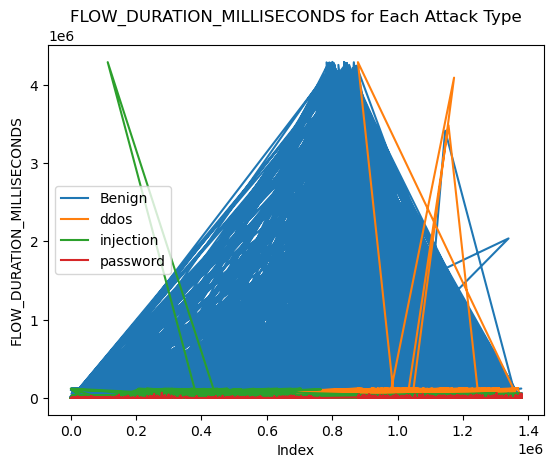

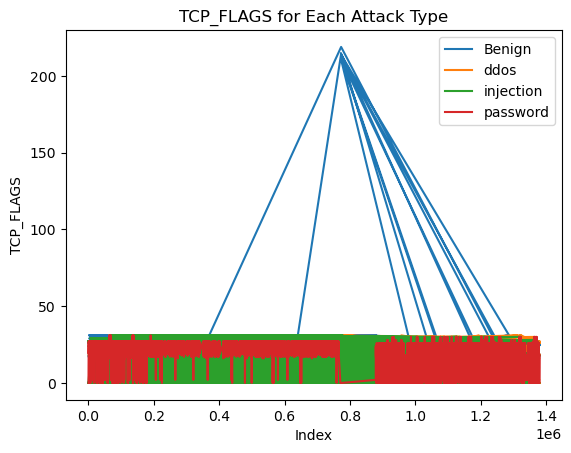

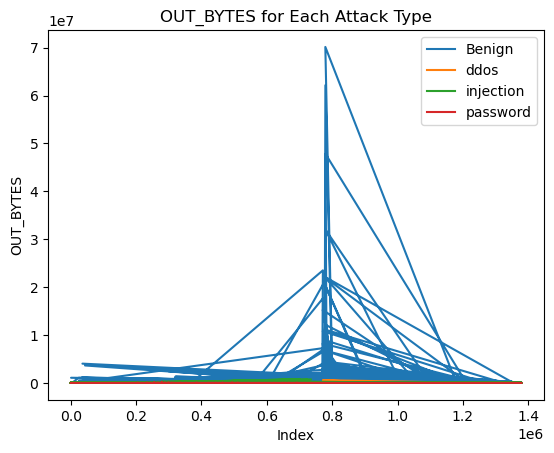

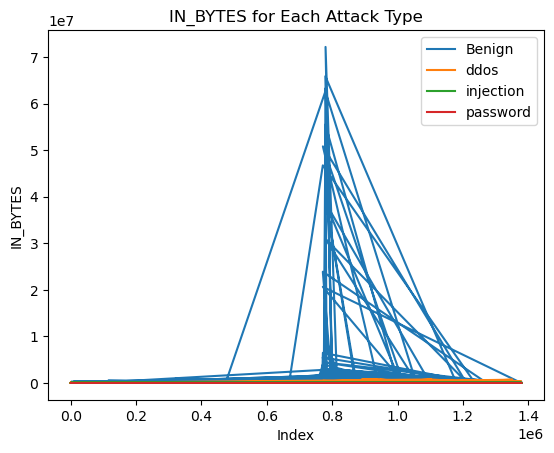

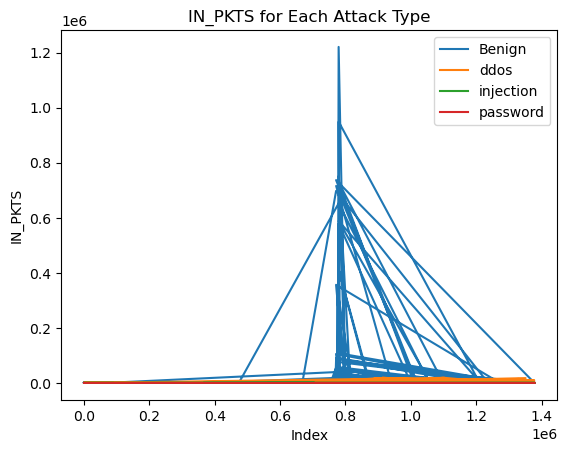

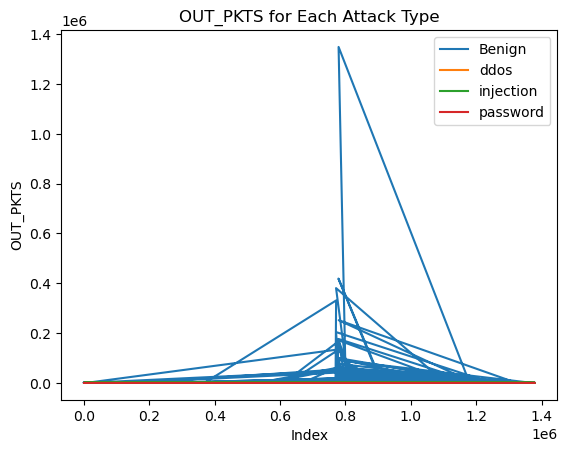

In [10]:
# Create DataFrame
df = pd.DataFrame(data)

# Group by attack type
grouped = df.groupby('Attack')

# Plot for each feature
features = ['FLOW_DURATION_MILLISECONDS', 'TCP_FLAGS', 'OUT_BYTES', 'IN_BYTES', 'IN_PKTS', 'OUT_PKTS']
for feature in features:
    plt.figure()
    for attack, group in grouped:
        plt.plot(group[feature], label=attack)
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.title(f'{feature} for Each Attack Type')
    plt.legend()
    plt.show()

In [11]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
811722,172.17.112.93:8080,192.168.1.193:49249,6,131.0,208,200,2,1,24,59,0,Benign
783287,172.27.43.105:44838,192.33.14.30:53,17,5.0,70,791,1,1,0,14,0,Benign
795907,172.21.101.196:51517,239.255.255.250:15600,17,0.0,126,0,2,0,0,3664929,0,Benign
876724,172.25.78.224:55334,224.0.0.252:5355,17,154.0,122,0,2,0,0,0,0,Benign
793121,172.28.234.249:10230,192.203.230.10:53,17,5.0,56,1125,1,1,0,19,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
1378908,172.23.170.51:55368,192.168.1.190:80,6,7.0,112,60,2,1,18,0,1,password
1378911,172.25.182.171:55370,192.168.1.190:80,6,7.0,112,60,2,1,18,0,1,password
1378914,172.23.152.112:55372,192.168.1.190:80,6,7.0,300,208,5,4,19,54351,1,password
1378926,172.18.25.63:39301,192.168.1.1:53,17,5.0,71,71,1,1,0,0,1,password


In [12]:
data.drop(columns=['Label'],inplace = True)

In [13]:
data.rename(columns={"Attack": "label"},inplace = True)

In [14]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [15]:
label = data.label

In [16]:
data.drop(columns=['label'],inplace = True)

In [17]:
scaler = StandardScaler()

In [18]:
data =  pd.concat([data, label], axis=1)

In [19]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
811722,172.17.112.93:8080,192.168.1.193:49249,6,131.0,208,200,2,1,24,59,0
783287,172.27.43.105:44838,192.33.14.30:53,17,5.0,70,791,1,1,0,14,0
795907,172.21.101.196:51517,239.255.255.250:15600,17,0.0,126,0,2,0,0,3664929,0
876724,172.25.78.224:55334,224.0.0.252:5355,17,154.0,122,0,2,0,0,0,0
793121,172.28.234.249:10230,192.203.230.10:53,17,5.0,56,1125,1,1,0,19,0
...,...,...,...,...,...,...,...,...,...,...,...
1378908,172.23.170.51:55368,192.168.1.190:80,6,7.0,112,60,2,1,18,0,3
1378911,172.25.182.171:55370,192.168.1.190:80,6,7.0,112,60,2,1,18,0,3
1378914,172.23.152.112:55372,192.168.1.190:80,6,7.0,300,208,5,4,19,54351,3
1378926,172.18.25.63:39301,192.168.1.1:53,17,5.0,71,71,1,1,0,0,3


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.4, random_state=42,stratify= label)

In [ ]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [22]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [23]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [24]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [25]:
G = G.to_directed()


In [26]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [27]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [28]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [29]:
G

Graph(num_nodes=402612, num_edges=750234,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})

In [30]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [31]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [32]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [33]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [34]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [35]:
G.ndata['h']

tensor([[[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]]])

In [36]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 4)
    def forward(self, g_dgl, nfeats, efeats):
        h = self.gnn(g_dgl, nfeats, efeats)
        return self.pred(g_dgl, h)

In [37]:
from sklearn.utils import class_weight
class_weights = [5.1032e+01, 4.2264e+00, 5.9438e+01,
        8.8245e+01]

In [38]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [39]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [40]:
G.ndata['h'].device


device(type='cuda', index=0)

In [41]:
G.edata['h'].device


device(type='cuda', index=0)

In [42]:
G.ndata['h'].shape[2]

8

In [43]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,1000):
    pred = model(G, node_features, edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.5288403630256653
Training acc: 0.6857886910438538
Training acc: 0.6864244937896729
Training acc: 0.708220362663269
Training acc: 0.7167710065841675
Training acc: 0.7280755043029785
Training acc: 0.7172428965568542
Training acc: 0.7274130582809448
Training acc: 0.7477827072143555


In [44]:
model

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=16, out_features=128, bias=True)
        (W_apply): Linear(in_features=136, out_features=128, bias=True)
      )
      (1): SAGELayer(
        (W_msg): Linear(in_features=136, out_features=128, bias=True)
        (W_apply): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [45]:
X_test = encoder.transform(X_test)

C:\Users\cayde\anaconda3\envs\fuckoff\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cayde\anaconda3\envs\fuckoff\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cayde\anaconda3\envs\fuckoff\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .filln

In [46]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [47]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
1123905,172.29.10.230:443,192.168.1.30:35334,0.307756,-1.081414,-0.008199,-0.018041,-0.006948,-0.010788,-1.869170,-0.058337,0
864356,172.27.126.206:61979,224.0.0.252:5355,-3.148565,-2.035004,-0.007939,-0.018041,-0.006707,-0.010788,-1.471064,-0.058337,0
652449,172.23.69.143:47154,192.168.1.184:443,0.307756,-1.081414,-0.004257,0.030348,-0.005019,0.000831,0.370005,-0.055968,2
1244683,172.19.143.134:35596,192.168.1.184:443,0.307756,-1.081414,-0.007976,-0.017659,-0.006707,-0.009732,-0.060039,-0.058337,1
1168810,172.28.167.23:80,192.168.1.30:59692,0.307756,0.778148,-0.007947,-0.017378,-0.006707,-0.008675,-0.060039,-0.011474,0
...,...,...,...,...,...,...,...,...,...,...,...
1018365,172.18.161.218:443,192.168.1.30:33292,0.307756,-1.081414,-0.008199,-0.017710,-0.006948,-0.009732,-1.869170,-0.058276,0
829803,172.29.229.206:56274,192.168.1.79:7678,0.307756,0.778148,-0.006615,-0.005053,-0.005501,-0.002338,0.900057,-0.058337,0
849405,172.26.236.74:8080,192.168.1.193:55985,0.307756,-2.035004,-0.007620,-0.016766,-0.006707,-0.009732,-1.764282,-0.057926,0
823886,172.18.177.93:8080,192.168.1.193:49377,0.307756,-2.035004,-0.007620,-0.016766,-0.006707,-0.009732,-1.764282,-0.057918,0


In [48]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [49]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
A_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [50]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [51]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [52]:
G_test = G_test.to('cuda:0')


In [53]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [54]:
print(str(elapsed) + ' seconds')


0.30458590000034746 seconds


In [55]:
test_pred = test_pred.argmax(1)


In [56]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [57]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay


In [59]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

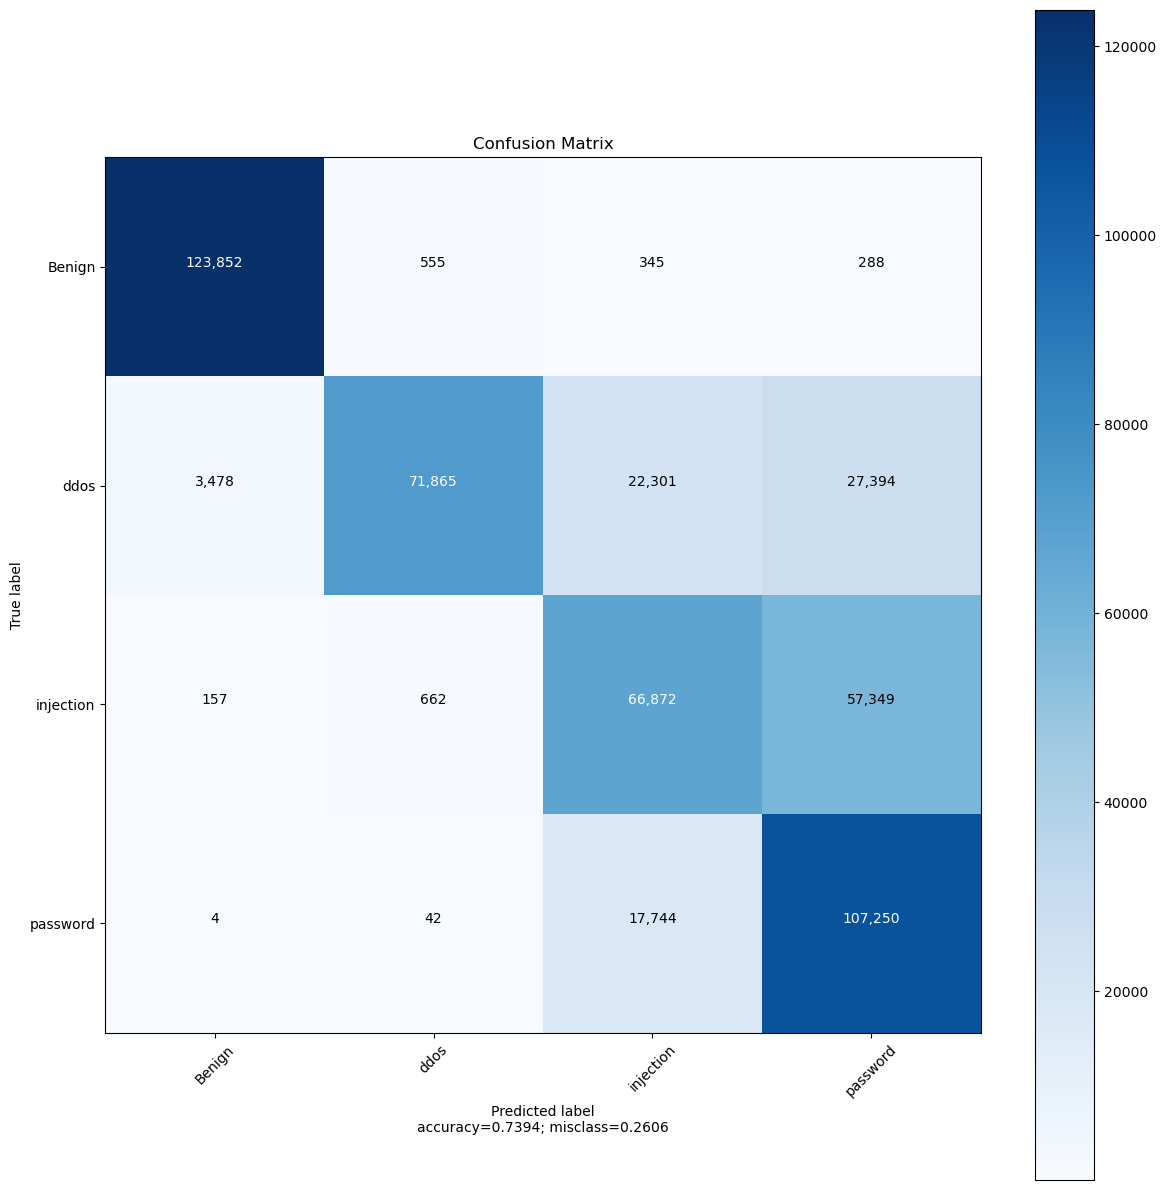

In [60]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [ ]:
#GNNEx

import torch_geometric.data as pyg

# Assuming G_test is your DGL graph
edges = G.edges()

# Convert node features from DGL to PyG format
node_features = th.tensor(G.ndata['h'])

# Convert edge features from DGL to PyG format
edge_features = th.tensor(G.edata['h'])

# Get edge indices from DGL graph
# Concatenate source and destination tensors along dim=0
edge_index = th.stack([edges[0], edges[1]], dim=0)

print("Edge index before transpose:")
print(edge_index)

# Transpose the edge index tensor
edge_index = edge_index.long().contiguous()
edge_index = edge_index.view(2, -1)

print("\nEdge index after transpose:")
print(edge_index)

# Create PyG Data object
pyg_graph = pyg.Data(
    x=node_features,  # Node features
    edge_index=edge_index,  # Edge indices
    efeats=edge_features  # Edge features
)

# Print PyG graph information
print(pyg_graph)

In [62]:
edges[1]

tensor([374531, 132675, 117334,  ..., 399977, 245336, 374582], device='cuda:0')

In [63]:
homoG = dgl.to_homogeneous(G)
netX = dgl.to_networkx(homoG.cpu())

In [64]:
dataX = torch_geometric.utils.from_networkx(netX)

In [65]:
G

Graph(num_nodes=402612, num_edges=750234,
      ndata_schemes={'h': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(1, 8), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})

In [66]:
model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()

In [67]:
from torch_geometric.data import HeteroData
from torch_geometric.explain import Explainer, CaptumExplainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',
    ),
)

# Generate explanation for the node at index `10`:
explanation = explainer(pyg_graph.x, pyg_graph.edge_index, efeats=pyg_graph.efeats, index=10)
print(explanation.edge_mask)
print(explanation.node_mask)

AttributeError: 'Tensor' object has no attribute 'local_scope'

In [138]:
pyg_graph.x

tensor([[[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')

In [139]:
model

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=16, out_features=128, bias=True)
        (W_apply): Linear(in_features=136, out_features=128, bias=True)
      )
      (1): SAGELayer(
        (W_msg): Linear(in_features=136, out_features=128, bias=True)
        (W_apply): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [140]:
print(model.gnn)

SAGE(
  (layers): ModuleList(
    (0): SAGELayer(
      (W_msg): Linear(in_features=16, out_features=128, bias=True)
      (W_apply): Linear(in_features=136, out_features=128, bias=True)
    )
    (1): SAGELayer(
      (W_msg): Linear(in_features=136, out_features=128, bias=True)
      (W_apply): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
)


In [141]:
model.gnn(G_test, nfeats, efeats)

NameError: name 'nfeats' is not defined

In [ ]:
dataX

In [ ]:
pyg_graph

In [ ]:
G_test.edata['h'].size()

In [ ]:
netX

In [ ]:
G

In [ ]:
g_dgl

In [ ]:
from torch_geometric.data import HeteroData
from torch_geometric.explain import Explainer, CaptumExplainer

hetero_data = HeteroData(pyg_graph)  # A heterogeneous graph data object.

explainer = Explainer(
    model(G, node_features, edge_features).cuda(),  # It is assumed that model outputs a single tensor.
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config = dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',  # Model returns probabilities.
    ),
)

# Generate batch-wise heterogeneous explanations for
# the nodes at index `1` and `3`:
hetero_explanation = explainer(
    hetero_data.x_dict,
    hetero_data.edge_index_dict,
    index=torch.tensor([10, 15]),
)
print(hetero_explanation.edge_mask_dict)
print(hetero_explanation.node_mask_dict)

In [ ]:
dataX

In [ ]:
hetero_data

In [ ]:
homoG

In [ ]:
dataX

In [ ]:
G_test

In [ ]:
G_test.ndata['feature']

In [ ]:
G

In [159]:
model(G, nfeats=pyg_graph.x, efeats=pyg_graph.efeats)

Graph(num_nodes=439803, num_edges=827564,
      ndata_schemes={'h': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(1, 8), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})
Graph(num_nodes=439803, num_edges=827564,
      ndata_schemes={'h': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(1, 8), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})
tensor([[[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')
tensor([[[ 0.7517, -1.9390, -0.0565,  ...,  0.3128, -0.0121, -0.0062]],

        [[ 0.7517, -1.9390, -0.0565,  ...,  0.3128, -0.0121, -0.0062]],

        [[ 

tensor([[ 0.0328, -0.0500,  0.0222,  ...,  0.0578, -0.0310, -0.0816],
        [ 0.0211,  0.0176,  0.0318,  ...,  0.0257, -0.0167, -0.0831],
        [ 0.0368,  0.0172,  0.0359,  ...,  0.0440, -0.0581, -0.0589],
        ...,
        [ 0.0950, -0.0137,  0.1075,  ...,  0.0329, -0.0499, -0.0844],
        [ 0.0369,  0.0074,  0.0822,  ...,  0.0663, -0.0032, -0.0710],
        [ 0.0695, -0.0048,  0.1058,  ...,  0.0345, -0.0335, -0.0596]],
       device='cuda:0', grad_fn=<AddmmBackward0>)